# Unet_Segmentation

## 필요 모듈 import

In [1]:
#필요한 라이브러리를 로드합니다. 
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *


print('슝=3')

슝=3


## Albumentation 사용법 알아보기 
-  Compose() : Albumentation에서 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 함수 
- imgaug의 Sometimes()와 유사한 기능

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
    if is_train:    # 훈련용 데이터일 경우
        return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
    return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행합니다. 
                Resize(
                    width=224,
                    height=224
                    )
                ])

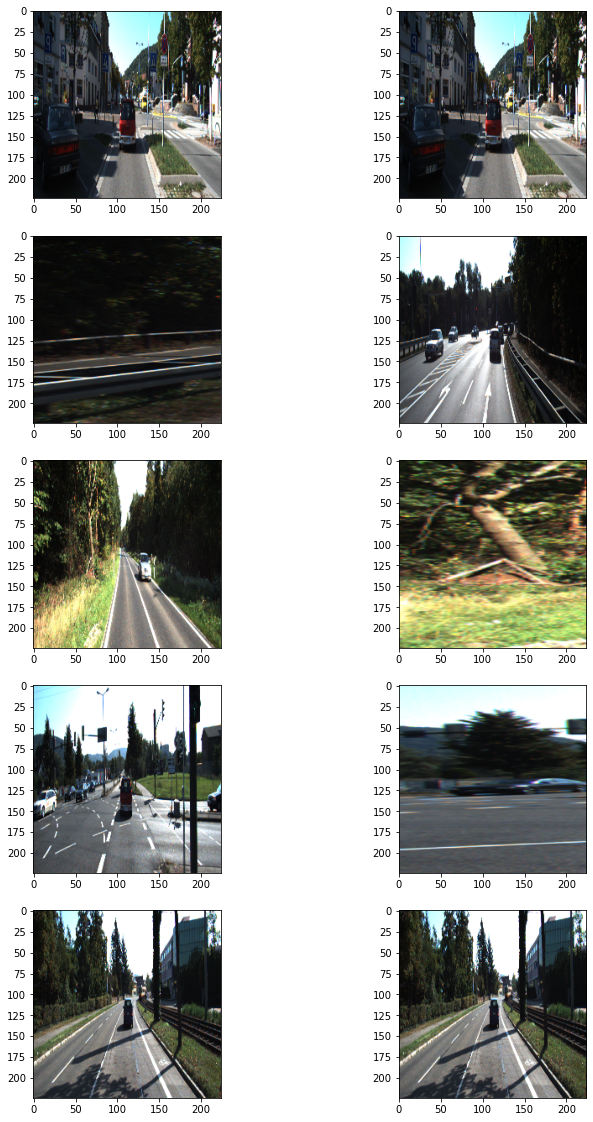

In [20]:

dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation = build_augmentation()
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용해 봅시다.  
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation(**image_data, is_train=False)
    processed = augmentation(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()


In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
    '''
    KittiGenerator는 tf.keras.utils.Sequence를 상속받습니다.
    우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용합니다.
    '''
    def __init__(self, 
                 dir_path,
                 batch_size=4,
                 img_size=(224, 224, 3),
                 output_size=(224, 224),
                 is_train=True,
                 augmentation=None):
        '''
        dir_path: dataset의 directory path입니다.
        batch_size: batch_size입니다.
        img_size: preprocess에 사용할 입력이미지의 크기입니다.
        output_size: ground_truth를 만들어주기 위한 크기입니다.
        is_train: 이 Generator가 학습용인지 테스트용인지 구분합니다.
        augmentation: 적용하길 원하는 augmentation 함수를 인자로 받습니다.
        '''
        self.dir_path = dir_path
        self.batch_size = batch_size
        self.is_train = is_train
        self.dir_path = dir_path
        self.augmentation = augmentation
        self.img_size = img_size
        self.output_size = output_size

        # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인합니다.
        self.data = self.load_dataset()

    def load_dataset(self):
        # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수입니다.
        # 이때 is_train에 따라 test set을 분리해서 load하도록 해야합니다.
        input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
        label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
        input_images.sort()
        label_images.sort()
        assert len(input_images) == len(label_images)
        data = [ _ for _ in zip(input_images, label_images)]

        if self.is_train:
            return data[:-30]
        return data[-30:]
    
    def __len__(self):
        # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환합니다.
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, index):
        # 입력과 출력을 만듭니다.
        # 입력은 resize및 augmentation이 적용된 input image이고 
        # 출력은 semantic label입니다.
        batch_data = self.data[
                             index*self.batch_size:
                             (index + 1)*self.batch_size
                             ]
        inputs = np.zeros([self.batch_size, *self.img_size])
        outputs = np.zeros([self.batch_size, *self.output_size])
        
        for i, data in enumerate(batch_data):
            input_img_path, output_path = data
            _input = imread(input_img_path)
            _output = imread(output_path)
            _output = (_output==7).astype(np.uint8)*1
            data = {
                "image": _input,
                "mask": _output,
                }
            augmented = self.augmentation(**data)
            inputs[i] = augmented["image"]/255
            outputs[i] = augmented["mask"]
            return inputs, outputs

    def on_epoch_end(self):
      # 한 epoch가 끝나면 실행되는 함수입니다. 학습중인 경우에 순서를 random shuffle하도록 적용한 것을 볼 수 있습니다.
        self.indexes = np.arange(len(self.data))
        if self.is_train == True :
            np.random.shuffle(self.indexes)
            return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 시맨틱 세그멘테이션 모델 U-Net 구현

In [13]:
def build_model(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

      #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

      #Expanding Path
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(drop5)) 
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

In [14]:
model = build_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 224, 224, 64) 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64) 0           conv2d_11[0][0]                  
____________________________________________________________________________________________

## UNet 모델 학습

In [15]:
model = build_model()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_path = dir_path + '/seg_model_unet2.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

Epoch 1/100
43/43 [==============================] - 18s 182ms/step - loss: 0.6927 - val_loss: 0.6415
Epoch 2/100
43/43 [==============================] - 8s 176ms/step - loss: 0.4498 - val_loss: 0.1364
Epoch 3/100
43/43 [==============================] - 8s 177ms/step - loss: 0.0990 - val_loss: 0.0877
Epoch 4/100
43/43 [==============================] - 8s 177ms/step - loss: 0.0890 - val_loss: 0.1031
Epoch 5/100
43/43 [==============================] - 8s 178ms/step - loss: 0.1147 - val_loss: 0.1134
Epoch 6/100
43/43 [==============================] - 8s 178ms/step - loss: 0.1178 - val_loss: 0.0787
Epoch 7/100
43/43 [==============================] - 8s 178ms/step - loss: 0.0760 - val_loss: 0.0794
Epoch 8/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0702 - val_loss: 0.0740
Epoch 9/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0724 - val_loss: 0.0660
Epoch 10/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0506 - val_l

43/43 [==============================] - 8s 179ms/step - loss: 0.0495 - val_loss: 0.0433
Epoch 82/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0382 - val_loss: 0.0448
Epoch 83/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0358 - val_loss: 0.0462
Epoch 84/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0440 - val_loss: 0.0446
Epoch 85/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0407 - val_loss: 0.0423
Epoch 86/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0388 - val_loss: 0.0503
Epoch 87/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0378 - val_loss: 0.0402
Epoch 88/100
43/43 [==============================] - 8s 180ms/step - loss: 0.0361 - val_loss: 0.0494
Epoch 89/100
43/43 [==============================] - 8s 180ms/step - loss: 0.0325 - val_loss: 0.0494
Epoch 90/100
43/43 [==============================] - 8s 179ms/step - loss: 0.0455 - val_loss: 

- 이전 스텝에서 저장된 모델은 이후 아래와 같이 로드해서 활용 가능

In [18]:
model_path = dir_path + '/seg_model_unet2.h5'
model = tf.keras.models.load_model(model_path)


##  IoU 계산치 확인하기

In [9]:
def get_output(model, preproc, image_path, output_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()
    return output

In [12]:
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

In [13]:
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라집니다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

In [19]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.802349


0.8023489715138538

![Unet](https://user-images.githubusercontent.com/60597598/116701580-088cc880-aa03-11eb-829d-9b1253aa1c55.png)

## U-Net++(A Nested U-Net) 만들기
- https://www.kaggle.com/ekhtiar/tf-tutorial-semantic-segmentation-with-u-net
- Unet에 concatenate를 적용하였다.

In [6]:
from keras.regularizers import l2


def standard_unit(input_tensor, stage, nb_filter, kernel_size=3):

    act = 'elu'
    smooth = 1.
    dropout_rate = 0.5
    
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(input_tensor)
    x = Dropout(dropout_rate, name='dp'+stage+'_1')(x)
    x = Conv2D(nb_filter, (kernel_size, kernel_size), activation=act, name='conv'+stage+'_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(x)
    x = Dropout(dropout_rate, name='dp'+stage+'_2')(x)

    return x

def Nested_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)

    nb_filter = [32,64,128,256,512]
    act = 'elu'

    #Contracting Path
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2)
    conv1_2 = concatenate([up1_2, conv1], name='merge12', axis=3)
    conv1_2 = standard_unit(conv1_2, stage='12', nb_filter=nb_filter[0])    

    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3)
    conv2_2 = concatenate([up2_2, conv2], name='merge22', axis=3)
    conv2_2 = standard_unit(conv2_2, stage='22', nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1, conv1_2], name='merge13', axis=3)
    conv1_3 = standard_unit(conv1_3, stage='13', nb_filter=nb_filter[0])

    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4)
    conv3_2 = concatenate([up3_2, conv3], name='merge32', axis=3)
    conv3_2 = standard_unit(conv3_2, stage='32', nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2, conv2_2], name='merge23', axis=3)
    conv2_3 = standard_unit(conv2_3, stage='23', nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1, conv1_2, conv1_3], name='merge14', axis=3)
    conv1_4 = standard_unit(conv1_4, stage='14', nb_filter=nb_filter[0])

    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5)
    conv4_2 = concatenate([up4_2, conv4], name='merge42', axis=3)
    conv4_2 = standard_unit(conv4_2, stage='42', nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3, conv3_2], name='merge33', axis=3)
    conv3_3 = standard_unit(conv3_3, stage='33', nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = standard_unit(conv2_4, stage='24', nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1, conv1_2, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = standard_unit(conv1_5, stage='15', nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(1, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(1, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(1, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(1, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv1_5)    


    model = Model(inputs=inputs, outputs=[nestnet_output_4])
    return model


In [7]:
model = Nested_unet()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 45s 213ms/step - loss: 1.0750 - val_loss: 0.5522
Epoch 2/100
43/43 [==============================] - 9s 198ms/step - loss: 0.4974 - val_loss: 0.3918
Epoch 3/100
43/43 [==============================] - 9s 199ms/step - loss: 0.4322 - val_loss: 0.3575
Epoch 4/100
43/43 [==============================] - 9s 200ms/step - loss: 0.3704 - val_loss: 0.4026
Epoch 5/100
43/43 [==============================] - 9s 201ms/step - loss: 0.3892 - val_loss: 0.3107
Epoch 6/100
43/43 [==============================] - 9s 208ms/step - loss: 0.3407 - val_loss: 0.3536
Epoch 7/100
43/43 [==============================] - 9s 217ms/step - loss: 0.3622 - val_loss: 0.3066
Epoch 8/100
43/43 [==============================] - 9s 209ms/step - loss: 0.3318 - val_loss: 0.2935
Epoch 9/100
43/43 [==============================] - 9s 203ms/step - loss: 0.3357 - val_loss: 0.2891
Epoch 10/100
43/43 [==============================] - 9s 202ms/step - loss: 0.3031 - val_l

43/43 [==============================] - 9s 201ms/step - loss: 0.0984 - val_loss: 0.1117
Epoch 82/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0905 - val_loss: 0.0983
Epoch 83/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0866 - val_loss: 0.1040
Epoch 84/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0876 - val_loss: 0.0965
Epoch 85/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0893 - val_loss: 0.0894
Epoch 86/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0848 - val_loss: 0.0958
Epoch 87/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0810 - val_loss: 0.0959
Epoch 88/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0839 - val_loss: 0.0960
Epoch 89/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0906 - val_loss: 0.0921
Epoch 90/100
43/43 [==============================] - 9s 201ms/step - loss: 0.0888 - val_loss: 

In [8]:
model_path = dir_path + '/seg_model_Nested_unet.h5'
model.save(model_path)  #학습한 모델을 저장해 주세요.

In [17]:
model_path = dir_path + '/seg_model_Nested_unet.h5'
model = tf.keras.models.load_model(model_path)


In [18]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.763734


0.7637341280124385

## U-Net ++ 2 설계하기
- dropout을 적용하지 않고 concatenate을 적용한 U-Net++ 을 설계하였다.

In [8]:
from keras.regularizers import l2


def standard_unit(inputs, filters):

    conv2d = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv2d = Conv2D(filters, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2d)
    
    return conv2d

def Nested_unet2(input_shape=(224, 224, 3), num_class=1):
    
    
    inputs = Input(input_shape)
    conv_x00 = standard_unit(inputs, 64)
    
    pool_x10 = MaxPooling2D(pool_size=(2, 2))(conv_x00)
    conv_x10 = standard_unit(pool_x10, 128)
    
    upsm_x01 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x10)
    cnct_x01 = Concatenate(axis=3)([upsm_x01, conv_x00])
    conv_x01 = standard_unit(cnct_x01, 64)  
    
  
    pool_x20 = MaxPooling2D(pool_size=(2, 2))(conv_x10)
    conv_x20 = standard_unit(pool_x20, 256)
    
    upsm_x11 = Conv2DTranspose(128, 2, strides=(2, 2))(conv_x20)
    cnct_x11 = Concatenate(axis=3)([upsm_x11, conv_x10])
    conv_x11 = standard_unit(cnct_x11, 128)  
   
    upsm_x02 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x11)
    cnct_x02 = Concatenate(axis=3)([upsm_x02, conv_x01, conv_x00])
    conv_x02 = standard_unit(cnct_x02, 64)  
    
   
    pool_x30 = MaxPooling2D(pool_size=(2, 2))(conv_x20)
    conv_x30 = standard_unit(pool_x30, 512)
    
    upsm_x21 = Conv2DTranspose(256, 2, strides=(2, 2))(conv_x30)
    cnct_x21 = Concatenate(axis=3)([upsm_x21, conv_x20])
    conv_x21 = standard_unit(cnct_x21, 256)  
   
    upsm_x12 = Conv2DTranspose(128, 2, strides=(2, 2))(conv_x21)
    cnct_x12 = Concatenate(axis=3)([upsm_x12, conv_x11, conv_x10])
    conv_x12 = standard_unit(cnct_x12, 128)
    
    upsm_x03 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x12)
    cnct_x03 = Concatenate(axis=3)([upsm_x03, conv_x02, conv_x01, conv_x00])
    conv_x03 = standard_unit(cnct_x03, 64)     
    

    pool_x40 = MaxPooling2D(pool_size=(2, 2))(conv_x30)
    conv_x40 = standard_unit(pool_x40, 1024)
    
    upsm_x31 = Conv2DTranspose(512, 2, strides=(2, 2))(conv_x40)
    cnct_x31 = Concatenate(axis=3)([upsm_x31, conv_x30])
    conv_x31 = standard_unit(cnct_x31, 512)  
   
    upsm_x22 = Conv2DTranspose(256, 2, strides=(2, 2))(conv_x31)
    cnct_x22 = Concatenate(axis=3)([upsm_x22, conv_x21, conv_x20])
    conv_x22 = standard_unit(cnct_x22, 256)
    
    upsm_x13 = Conv2DTranspose(128, 2, strides=(2, 2))(conv_x22)
    cnct_x13 = Concatenate(axis=3)([upsm_x13, conv_x12, conv_x11, conv_x10])
    conv_x13 = standard_unit(cnct_x13, 128)       

    upsm_x04 = Conv2DTranspose(64, 2, strides=(2, 2))(conv_x13)
    cnct_x04 = Concatenate(axis=3)([upsm_x04, conv_x03,conv_x02, conv_x01, conv_x00])
    conv_x04 = standard_unit(cnct_x04, 64)
    
    UppNet_Output = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=l2(1e-4))(conv_x04)
    
    
    model = Model(inputs = inputs, outputs = UppNet_Output)
    return model


In [9]:
model = Nested_unet2()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
model = Nested_unet2()
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy')
model.fit_generator(
     generator=train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

/home/aiffel-dj17/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
43/43 [==============================] - 43s 342ms/step - loss: 0.5934 - val_loss: 0.1198
Epoch 2/100
43/43 [==============================] - 14s 330ms/step - loss: 0.1420 - val_loss: 0.0900
Epoch 3/100
43/43 [==============================] - 14s 332ms/step - loss: 0.1171 - val_loss: 0.0628
Epoch 4/100
43/43 [==============================] - 14s 334ms/step - loss: 0.0615 - val_loss: 0.0825
Epoch 5/100
43/43 [==============================] - 14s 335ms/step - loss: 0.0652 - val_loss: 0.1045
Epoch 6/100
43/43 [==============================] - 14s 335ms/step - loss: 0.1032 - val_loss: 0.0591
Epoch 7/100
43/43 [==============================] - 14s 337ms/step - loss: 0.0643 - val_loss: 0.0615
Epoch 8/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0645 - val_loss: 0.0595
Epoch 9/100
43/43 [==============================] - 14s 335ms/step - loss: 0.0474 - val_loss: 0.0800
Epoch 10/100
43/43 [==============================] - 14s 336ms/step - loss: 0.065

43/43 [==============================] - 14s 336ms/step - loss: 0.0379 - val_loss: 0.0416
Epoch 81/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0357 - val_loss: 0.0474
Epoch 82/100
43/43 [==============================] - 14s 337ms/step - loss: 0.0342 - val_loss: 0.0593
Epoch 83/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0365 - val_loss: 0.0923
Epoch 84/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0521 - val_loss: 0.0396
Epoch 85/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0423 - val_loss: 0.0424
Epoch 86/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0317 - val_loss: 0.0414
Epoch 87/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0360 - val_loss: 0.0356
Epoch 88/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0362 - val_loss: 0.0414
Epoch 89/100
43/43 [==============================] - 14s 336ms/step - loss: 0.0322 - 

In [14]:
# 완성한 뒤에는 시각화한 결과를 눈으로 확인해봅시다!
i = 1    # i값을 바꾸면 테스트용 파일이 달라집니다. 
output, prediction, target = get_output(
     model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.821617


0.8216169876022158

![Unet_N2](https://user-images.githubusercontent.com/60597598/116701140-87353600-aa02-11eb-943e-21e9332916db.png)

### 결과 정리
 - Unet IoU : 0.80
 - Unet ++ IoU : 0.76
 - Unet ++ 2 IoU : 0.82
 
 - dropout을 적용하지 않은 Unet++ 가 성능이 향상되었다.

### 루브릭 평가문항	
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?
- KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물 시각화의 한사이클이 정상수행되어 세그멘테이션 결과이미지를 제출하였다.   

2. U-Net++ 모델이 성공적으로 구현되었는가?
- U-Net++ 모델을 스스로 구현하여 학습 진행 후 세그멘테이션 결과까지 정상진행되었다.   

3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?
- U-Net++ 의 세그멘테이션 결과 사진과 IoU 계산치를 U-Net과 비교하여 우월함을 확인하였다.